# Analysis of Bamberg Pain sample (40 vids)
B.L. de Vries - 3/12/2018

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import glob
import time
import pandas as pd
import matplotlib.pyplot as plt

import exploface
import elanwriter

In [4]:
verbose=False

### Directories used in this notebook
First I will make variables holding the different directories with input and output files and the executables of openface

I use openface via a python wrapper script ```analyse_video``` that I made. This is just a very simple wrapper. I also define the openface executable here.

In [5]:
openface_runner_path = os.path.join("C:\\","Users","bldev","Dropbox","0_DATA_BEN","WORK_ESCIENCE","PROJECTS","DEMENTIA","TOOLS","openface_runner")
sys.path.append(openface_runner_path)
from process_video import analyse_video

openface_version_dir = "OpenFace_2.0.5_win_x64"
openface_exe = os.path.join("C:\\","Users","bldev","Dropbox","0_DATA_BEN",
                            "WORK_ESCIENCE","PROJECTS","DEMENTIA","TOOLS","openface_runner",
                            openface_version_dir,"FeatureExtraction.exe")

These are the input directories

(Note: E: is an encrypted disk)

In [6]:
video_dir = os.path.join("E:\\","PROJECT_DATA","DEMENTIA_2017","BAMBERG","videos")
FACS_dir = os.path.join("E:\\","PROJECT_DATA","DEMENTIA_2017","BAMBERG","FACS_encoding","original")

And the output directories

In [7]:


output_dir = os.path.join("E:\\","PROJECT_DATA","DEMENTIA_2017","BAMBERG_ANALYSIS",
                          "v2_start_Dec2018_OpenFace_2.0.5_win_x64", "openface_output")
FACS_conv_dir = os.path.join("E:\\","PROJECT_DATA","DEMENTIA_2017","BAMBERG_ANALYSIS",
                          "v2_start_Dec2018_OpenFace_2.0.5_win_x64", "FACS_timestamp_files")
elan_output_dir = os.path.join("E:\\","PROJECT_DATA","DEMENTIA_2017","BAMBERG_ANALYSIS",
                          "v2_start_Dec2018_OpenFace_2.0.5_win_x64", "elan_output")
plot_output_dir = os.path.join("E:\\","PROJECT_DATA","DEMENTIA_2017","BAMBERG_ANALYSIS",
                          "v2_start_Dec2018_OpenFace_2.0.5_win_x64", "plots")

Since we use external encrypted disks, lets check if we have access to the directories

In [8]:
os.path.isfile(openface_exe), os.path.isdir(video_dir), os.path.isdir(output_dir), os.path.isdir(elan_output_dir), os.path.isdir(FACS_dir), os.path.isdir(FACS_conv_dir)

(True, True, True, True, True, True)

Now we collect all the video files for analysis

In [9]:
video_file_paths = glob.glob(os.path.join(video_dir, "*"))
video_file_names = []

for v in video_file_paths:
    video_file_names.append(os.path.basename(v))
"Number of files: {}".format(len(video_file_paths))

'Number of files: 40'

### Running openface

In [10]:
print("Running videos from directory: ", video_dir)
for i, v in enumerate(video_file_names):
    if verbose: print("- "+str(i+1)+"/"+str(len(video_file_names))+": "+v)
    start_time = time.time()
    
    openface_output_filename_no_ext = v.split(".")[0]
    output_filename = openface_output_filename_no_ext+".csv"
    
    if not os.path.isfile(os.path.join(output_dir, output_filename)):
        analyse_video(verbose=False, 
                  inputpath = video_dir,
                  filename = v,
                  outputpath = output_dir, 
                  openface_feat_exe = openface_exe, 
                  execute=True)
        # META DATA OPENFACE AND EXPLOFACE
        with open(os.path.join(output_dir, openface_output_filename_no_ext+".version_log"), "w") as text_file:
            print("Datetime: {}".format(time.strftime("%c")), file=text_file)
            print("Version exploface: {}".format(exploface.__version__), file=text_file)
            print("Version openface: {}".format(openface_version_dir), file=text_file)
    else:
        if verbose: print("   Output exists, not running")
    if verbose: print("   Execution time: %s min" % round((time.time() - start_time)/60, 2))
    

Running videos from directory:  E:\PROJECT_DATA\DEMENTIA_2017\BAMBERG\videos


### Converting format of FACS encoders

In [11]:
# FACS_dir 
# FACS_conv_dir

# Get all the files with a glob
xls_files_facs = glob.glob(FACS_dir+'/**/*'+".xlsx", recursive=True)
# Get the numbers in the filenames that identify the video it belongs to
xls_numbers = [os.path.basename(f).split("-")[1].split("_")[0][1:4] for f in xls_files_facs]
# Example of how to read in the content of the xlsx files

FACS_detections = {}
for i,xls_file in enumerate(xls_files_facs):
    if verbose: print(xls_file)
    new_file_name = "FACS_"+xls_numbers[i]+"_timestamp.csv"

    if os.path.isfile(os.path.join(FACS_conv_dir, new_file_name)):
        if verbose: print("    On disk")
        df_human = pd.read_csv(os.path.join(FACS_conv_dir, new_file_name))
    else:
        if verbose: print("    Running")
        dataframe = pd.read_excel(xls_file,skipinitialspace=True )    
        df_human = exploface.conversions.convert_bamberg_to_timestamp_format(dataframe)
        df_human.to_csv(os.path.join(FACS_conv_dir, new_file_name))

    df_human["feature"] = df_human["feature"]+"_FACS"
        
    FACS_detections[xls_numbers[i]] = df_human


### Make masks for openface results to match FACS encoding
The encoders only encoded 5 SEC after the pain marker is on.

In [12]:
openface_mask_dict = {}
room =5 #s
time_after_pain = 5 #s

for i, v in enumerate(video_file_names):
    nr = v.split("_")[0]
    video_output_filename_no_ext = v.split(".")[0]
    openface_csv_file = video_output_filename_no_ext+".csv"
    openface_csv_path = os.path.join(output_dir, openface_csv_file)
    
    openface_mask_file = video_output_filename_no_ext+"_mask.csv"
    openface_mask_path = os.path.join(FACS_conv_dir, openface_mask_file)
    
    if verbose: print(nr)
    if not os.path.isfile(openface_mask_path):
        openface_time_series = exploface.get_feature_time_series(openface_csv_path)

        facs_mask_times = FACS_detections[nr][FACS_detections[nr]["feature"]=="pain_start_FACS"]


        mask = []
        for j, row in openface_time_series.iterrows():
            imask = 0
            for k, row_facs in facs_mask_times.iterrows():
                if  row["timestamp"] < row_facs["end"]+time_after_pain+room and \
                    row["timestamp"] > row_facs["start"]-room:
                    imask = 1
            mask.append(imask)

        openface_mask = pd.DataFrame({"timestamp": openface_time_series["timestamp"], "mask": mask})

        openface_mask_dict[v.split("_")[0]] = openface_mask
        
        openface_mask.to_csv(openface_mask_path)
    
    else:
        openface_mask_dict[v.split("_")[0]] = pd.read_csv(openface_mask_path)#openface_time_series



### Example of a masking

(0, 200)

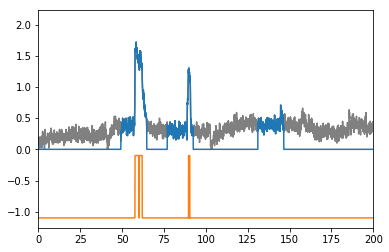

In [13]:
au = "AU12"
v = video_file_names[0]



video_output_filename_no_ext = v.split(".")[0]
openface_csv_file = video_output_filename_no_ext+".csv"
openface_csv_path = os.path.join(output_dir, openface_csv_file)        

openface_time_series = exploface.get_feature_time_series(openface_csv_path)

mask = openface_mask_dict[v.split("_")[0]]

#openface_time_series.loc[:, openface_time_series.columns != 'timestamp'] *mask["mask"]
for col in [c for c in openface_time_series.columns if c != "timestamp"]:
    openface_time_series[col+"_mask"] = openface_time_series[col].where(mask["mask"]>0, 0)
    
#openface_time_series_masked = 
#openface_time_series_masked["timestamp"] = openface_time_series["timestamp"]
#openface_time_series[au] = openface_time_series[au]*mask["mask"]
#openface_time_series.loc[:, ("AU06_r", (mask["mask"]==1))] =0

plt.plot(openface_time_series["timestamp"],openface_time_series[au+"_r"], "grey")
plt.plot(openface_time_series["timestamp"],openface_time_series[au+"_r_mask"])
plt.plot(openface_time_series["timestamp"],openface_time_series[au+"_c_mask"]-1.1)
#plt.plot(mask["timestamp"], mask["mask"])
plt.xlim(0, 200)


### Generating detections and writing Elan files

In [16]:
verbose=True

force=False

openface_detections_dict = {}
openface_time_series_dict = {}
detections_settings_dict = {}
for i, v in enumerate(video_file_names):

    #####################
    # DIRECTORIES
    #####################
    video_output_filename_no_ext = v.split(".")[0]
    openface_csv_file = video_output_filename_no_ext+".csv"
    openface_csv_file_masks = video_output_filename_no_ext+"_masks.csv"
    openface_csv_path = os.path.join(output_dir, openface_csv_file)
    openface_avi_path = os.path.join(output_dir, video_output_filename_no_ext+".avi")
    elan_output_path = os.path.join(elan_output_dir, video_output_filename_no_ext+".eaf")
    detections_output_path = os.path.join(elan_output_dir, video_output_filename_no_ext+"_detections.csv")
    detection_settings_output_path = os.path.join(elan_output_dir, video_output_filename_no_ext+"_detection_settings.csv")
    
    if verbose: 
        print("- "+str(i+1)+"/"+str(len(video_file_names))+": "+os.path.basename(detections_output_path))
        print("     files found: ", os.path.isfile(detections_output_path))

    if not os.path.isfile(detections_output_path) or force:
        #####################
        # OPENFACE
        #####################
        openface_time_series = exploface.get_feature_time_series(openface_csv_path)

        # Apply the masks to all columns (except the timestamp)
        mask = openface_mask_dict[v.split("_")[0]]
        for col in [c for c in openface_time_series.columns if c != "timestamp"]:
            openface_time_series[col+"_mask"] = openface_time_series[col].where(mask["mask"]>0, 0)

        columns = {\
            "name":[],\
            "intensity_threshold":[],\
            "smooth_time_threshold":[],\
            "time_threshold":[],\
            "method":[],\
            "inverse_threshold":[],\
        }

        # Default thresholds
        method="threshold"
        inverse_threshold=False
        intensity_threshold=0.8
        time_threshold=0.1
        smooth_time_threshold = 0.1
        uncertainty_threshold=0.9
        
        # Column selection list
        col_select_strings = ["AU", "_mask"]

        # Making column name and threshold settings dataframe
        for j, c in enumerate(openface_time_series.columns):
            if c == 'confidence':
                columns["name"].append( c )
                columns["intensity_threshold"].append(intensity_threshold)
                columns["smooth_time_threshold"].append(smooth_time_threshold)
                columns["time_threshold"].append(time_threshold)
                columns["method"].append(method)
                columns["inverse_threshold"].append(True)
            if all([s in c for s in col_select_strings]):#"AU" in c and "_r" in c:
                columns["name"].append( c )
                columns["intensity_threshold"].append(intensity_threshold)
                columns["smooth_time_threshold"].append(smooth_time_threshold)
                columns["time_threshold"].append(time_threshold)
                columns["method"].append(method)
                columns["inverse_threshold"].append(inverse_threshold)

        columns = pd.DataFrame(columns)

        # Running exploface
        openface_detections = exploface.get_detections(openface_time_series, only_columns=columns)


        #####################
        # OUTPUTTING
        #####################
        # 
        openface_time_series.to_csv(os.path.join(FACS_conv_dir, openface_csv_file_masks))
        
        # And the merged dections
        openface_detections.to_csv(detections_output_path) # Save without FACS
        
        # Writing out the settings
        columns.to_csv(detection_settings_output_path)
        
       
        # Now combine with the facs
        df_facs = FACS_detections[v.split("_")[0]]
        detections = pd.concat([openface_detections, df_facs])
        
        # Save the elan file
        elanwriter.write_elan_file(detections, 
                                   video_path=openface_avi_path, 
                                   output_path=elan_output_path,
                                   feature_col_name = "feature")

        # Make a dict with openface detections for further analysis
        openface_detections_dict[v.split("_")[0]] = openface_detections
        openface_time_series_dict[v.split("_")[0]] = openface_time_series
        detections_settings_dict[v.split("_")[0]] = columns
        
    else:
        if verbose: print("     Loading")
        openface_detections_dict[v.split("_")[0]] = pd.read_csv(detections_output_path)#openface_detections
        openface_time_series_dict[v.split("_")[0]] = pd.read_csv(os.path.join(FACS_conv_dir, openface_csv_file_masks))  #openface_time_series #exploface.get_feature_time_series(openface_csv_path)
        detections_settings_dict[v.split("_")[0]] = pd.read_csv(detection_settings_output_path)#columns


- 1/40: 003_VL_detections.csv
     files found:  True
     Loading
- 2/40: 004_VL_detections.csv
     files found:  True
     Loading
- 3/40: 007_VL_detections.csv
     files found:  True
     Loading
- 4/40: 008_VL_detections.csv
     files found:  True
     Loading
- 5/40: 010_VL_detections.csv
     files found:  True
     Loading
- 6/40: 011_VL_detections.csv
     files found:  True
     Loading
- 7/40: 017_VL_detections.csv
     files found:  True
     Loading
- 8/40: 020_VL_detections.csv
     files found:  True
     Loading
- 9/40: 021_VL_detections.csv
     files found:  True
     Loading
- 10/40: 024_VL_detections.csv
     files found:  True
     Loading
- 11/40: 025_VL_detections.csv
     files found:  True
     Loading
- 12/40: 028_VL_detections.csv
     files found:  True
     Loading
- 13/40: 031_VL_detections.csv
     files found:  True
     Loading
- 14/40: 036_VL_detections.csv
     files found:  True
     Loading
- 15/40: 040_VL_detections.csv
     files found:  True
  

# Do the statistics

### Note we use this openface feature:

In [17]:
openface_det_method = "_c"

### Run over the videos

In [18]:
room = 5
stats = {}
AUs = [i.split("_")[0] for i in list(set(FACS_detections["003"]["feature"])) if "AU" in i]
AUs_of = [i.split("_")[0] for i in list(set(openface_detections_dict["003"]["feature"])) if "AU" in i]
AUs = list(set(AUs) - (set(AUs_of)-set(AUs)))


for i, value in enumerate(AUs):
    stats[value]={"overlap": [], "total_facs": [], "total_openface":[]}

for i, v in enumerate(video_file_names):
    nr=v.split("_")[0]
    df_openface = openface_detections_dict[nr]
    df_FACS = FACS_detections[nr]

    if i % 10==0: print(nr+"...")


    for au in AUs:

        nr_in_1_also_found_in_2, nr_in_2_also_found_in_1, total1, total2 = \
            exploface.analysis.compare_detections(df_openface, 
                                                  df_FACS, 
                                                  au+openface_det_method+"_mask", 
                                                  au+"_FACS", 
                                                  key_index="feature", 
                                                  room=room)

        openface_found = nr_in_2_also_found_in_1

        df_openface[df_openface['feature']==au+openface_det_method+"_mask"]
        df_FACS[df_FACS['feature']==au+"_FACS"]
        #print(au, round(openface_found, 2), total1, total2)
    
        stats[au]["overlap"].append(openface_found)
        stats[au]["total_facs"].append(total2)
        stats[au]["total_openface"].append(total1)
    #df_openface["start"]
    


003...
025...
056...
087...


In [19]:
performance = {"au":[], "overlap":[], "nr_of":[], "nr_facs":[], "overlap_std":[], "nr_of_std":[], "nr_facs_std":[]}
for au in AUs:
    df = pd.DataFrame(stats[au])
    performance["overlap"].append( df["overlap"].mean() )#sum(stats[au]["overlap"])/len(stats[au]["overlap"]) )
    performance["overlap_std"].append( df["overlap"].std() )
    performance["au"].append(au)
    performance["nr_of"].append( df["total_openface"].mean() )#sum(stats[au]["total_openface"])/len(stats[au]["total_openface"]) )
    performance["nr_of_std"].append( df["total_openface"].std() )
    performance["nr_facs"].append( df["total_facs"].mean() )#sum(stats[au]["total_facs"])/len(stats[au]["total_facs"]) )
    performance["nr_facs_std"].append( df["total_facs"].std() )
    

performance = pd.DataFrame(performance)
print(performance["overlap"].mean(), performance["overlap"].std())
performance= performance.sort_values(by=["au"])
performance

0.36161414824542815 0.2583231953440953


,au,nr_facs,nr_facs_std,nr_of,nr_of_std,overlap,overlap_std
8,AU04,8.475,5.349275,27.725,18.895105,0.719526,0.328865
7,AU06,5.100,4.378268,3.900,5.452828,0.340540,0.357361
9,AU07,6.675,4.958223,30.400,21.937908,0.698889,0.339539
6,AU09,2.075,2.973278,13.675,7.994830,0.560069,0.473962
0,AU10,4.025,3.392960,6.150,7.177422,0.411029,0.418178
10,AU12,1.225,2.142219,4.075,7.258549,0.130893,0.288869
1,AU14,4.200,4.438757,17.450,15.526569,0.494100,0.433037
4,AU15,0.625,1.102154,21.175,11.540092,0.160000,0.362894
5,AU17,2.275,2.183710,36.700,14.202203,0.462708,0.426933
2,AU18,1.825,1.946562,0.000,0.000000,0.000000,0.000000


[Text(0,0,'AU04'),
 Text(0,0,'AU06'),
 Text(0,0,'AU07'),
 Text(0,0,'AU09'),
 Text(0,0,'AU10'),
 Text(0,0,'AU12'),
 Text(0,0,'AU14'),
 Text(0,0,'AU15'),
 Text(0,0,'AU17'),
 Text(0,0,'AU18'),
 Text(0,0,'AU43')]

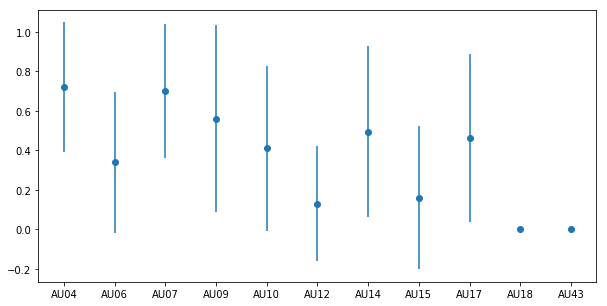

In [20]:
fig = plt.figure(figsize=(10,5)) 
ax = fig.add_subplot(1,1,1)
ax.errorbar(x = [i for i in performance["au"]], y=performance["overlap"], yerr = performance["overlap_std"],fmt='o')
ax.set_xticklabels(labels=performance["au"])

# Time to inspect the timeseries manually

In [18]:
nr = "008"
au = "AU07"
timestamp = "timestamp"

df_openface = openface_detections_dict[nr]
df_FACS = FACS_detections[nr]
openface_time_series = openface_time_series_dict[nr]
settings = detections_settings_dict[nr]

[c for c in openface_time_series.columns if not "AU" in c]
#openface_time_series[au+openface_det_method]
#openface_time_series.columns

['Unnamed: 0',
 'frame',
 'face_id',
 'timestamp',
 'confidence',
 'success',
 'gaze_0_x',
 'gaze_0_y',
 'gaze_0_z',
 'gaze_1_x',
 'gaze_1_y',
 'gaze_1_z',
 'gaze_angle_x',
 'gaze_angle_y',
 'eye_lmk_x_0',
 'eye_lmk_x_1',
 'eye_lmk_x_2',
 'eye_lmk_x_3',
 'eye_lmk_x_4',
 'eye_lmk_x_5',
 'eye_lmk_x_6',
 'eye_lmk_x_7',
 'eye_lmk_x_8',
 'eye_lmk_x_9',
 'eye_lmk_x_10',
 'eye_lmk_x_11',
 'eye_lmk_x_12',
 'eye_lmk_x_13',
 'eye_lmk_x_14',
 'eye_lmk_x_15',
 'eye_lmk_x_16',
 'eye_lmk_x_17',
 'eye_lmk_x_18',
 'eye_lmk_x_19',
 'eye_lmk_x_20',
 'eye_lmk_x_21',
 'eye_lmk_x_22',
 'eye_lmk_x_23',
 'eye_lmk_x_24',
 'eye_lmk_x_25',
 'eye_lmk_x_26',
 'eye_lmk_x_27',
 'eye_lmk_x_28',
 'eye_lmk_x_29',
 'eye_lmk_x_30',
 'eye_lmk_x_31',
 'eye_lmk_x_32',
 'eye_lmk_x_33',
 'eye_lmk_x_34',
 'eye_lmk_x_35',
 'eye_lmk_x_36',
 'eye_lmk_x_37',
 'eye_lmk_x_38',
 'eye_lmk_x_39',
 'eye_lmk_x_40',
 'eye_lmk_x_41',
 'eye_lmk_x_42',
 'eye_lmk_x_43',
 'eye_lmk_x_44',
 'eye_lmk_x_45',
 'eye_lmk_x_46',
 'eye_lmk_x_47',
 'ey

In [19]:
AUs.sort()
AUs

['AU04',
 'AU06',
 'AU07',
 'AU09',
 'AU10',
 'AU12',
 'AU14',
 'AU15',
 'AU17',
 'AU18',
 'AU43']

008


NameError: name 'legend_x' is not defined

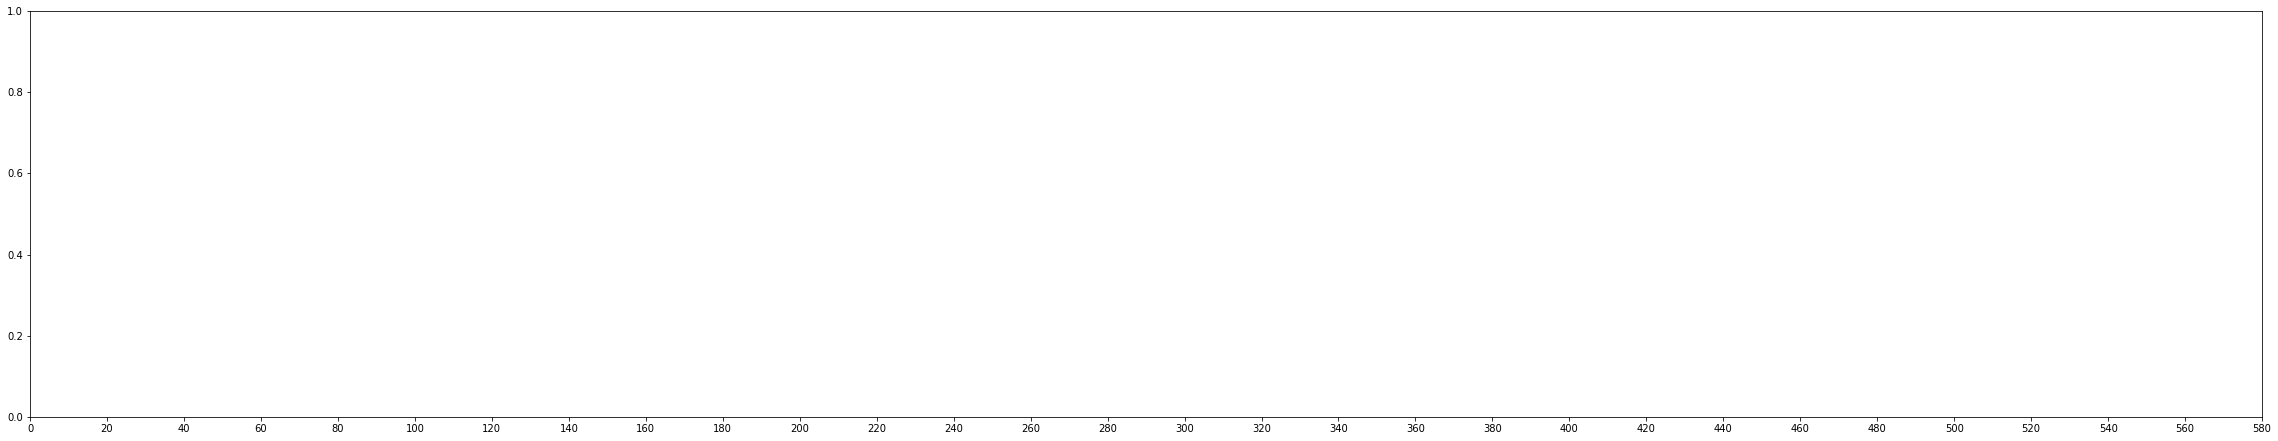

In [20]:
au_list = [au for au in AUs if au+openface_det_method in openface_time_series]

for j, v in enumerate(video_file_names):
    print(nr)
    nr=v.split("_")[0]
    df_openface = openface_detections_dict[nr]
    openface_time_series = openface_time_series_dict[nr]
    df_FACS = FACS_detections[nr]
    settings = detections_settings_dict[nr]

    fig = plt.figure(figsize=(40,80))
    #fig = plt.figure()
    plt.subplots_adjust(hspace=0.08)

    ax = plt.subplot(len(au_list)+1, 1, 1)
    ax.set_xticks([i*20 for i in range(int(600/20))])
    color="blue"
    plt.text(legend_x, 1, "confidence", fontsize = fontsize_legends, color=color)
    plt.plot(openface_time_series["timestamp"], openface_time_series["confidence"]+0, color=color)
    
    color="green"
    plt.text(legend_x, 0, "pose", fontsize = fontsize_legends, color=color)
    #plt.plot(openface_time_series["timestamp"], openface_time_series["pose_Rx"], color=color)
    #plt.plot(openface_time_series["timestamp"], openface_time_series["pose_Ry"], color=color)
    plt.plot(openface_time_series["timestamp"], openface_time_series["pose_Rz"], color=color)
    plt.ylabel(au, fontsize=25)
    plt.xlim(legend_x-5,565)
    plt.ylim(-0.5, 1.3)
    plt.xlabel("time (s)")
    plt.xticks(fontsize=25)#, rotation=90)
    plt.yticks(fontsize=25)

#     color="green"
#     plt.text(legend_x, 0.5, "gaze", fontsize = fontsize_legends, color=color)
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_0_x"]+0.5, color=color)
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_0_y"]+0.5, color=color)
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_0_z"]+0.5, color=color)
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_1_x"]+1.0, color="purple")
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_1_y"]+1.0, color="purple")
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_1_z"]+1.0, color="purple")
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_angle_x"]+1.5, color="teal")
#     plt.plot(openface_time_series["timestamp"], openface_time_series["gaze_angle_y"]+1.5, color="teal")
    
    for index, au in enumerate(au_list):
        #if i ==0:
        ax = plt.subplot(len(au_list)+1, 1, 1+index+1)
        ax.set_xticks([i*20 for i in range(int(600/20))])
        #else:
        #    ax = plt.subplot(len(au_list), 1, 1+index, sharex=ax)

        fontsize_legends = 24
        legend_x = -35
        color = "green"
        plt.text(legend_x, -1, "Openface", fontsize = fontsize_legends, color=color)
        plt.plot(openface_time_series["timestamp"], openface_time_series[au+"_r"]/5 -1, color="grey")
        plt.plot(openface_time_series["timestamp"], openface_time_series[au+"_r"+"_mask"]/5 -1, color=color)

        color="blue"
        plt.text(legend_x, 0, "Openface", fontsize = fontsize_legends, color=color)
        plt.plot(openface_time_series["timestamp"], openface_time_series[au+openface_det_method], color="grey")
        plt.plot(openface_time_series["timestamp"], openface_time_series[au+openface_det_method+"_mask"], color=color)

        color="grey"
        y_th = float(settings[settings["name"]==au+openface_det_method+"_mask"]["intensity_threshold"])
        plt.text(legend_x, y_th, "threshold", fontsize = fontsize_legends, color=color)
        plt.axhline(y_th, linestyle="-", color=color)

        slice_det = df_openface[df_openface["feature"] == au+openface_det_method+"_mask"]

        openface_det_loc = 1.3
        color = "red"
        #plt.axhline(openface_det_loc+0.01, color = color, linestyle="-.")
        plt.text(legend_x, openface_det_loc, "Exploface", color = color, fontsize=fontsize_legends)
        for i, row in slice_det.iterrows():
            start, end = row["start"], row["end"]
            plt.plot([start, end], [openface_det_loc, openface_det_loc], color=color,  linewidth=5)

        FACS_det_loc = 1.6
        color = "green"
        plt.text(legend_x, FACS_det_loc, "FACS", color = color, fontsize=fontsize_legends)
        for i, row in df_FACS[df_FACS["feature"]==au+"_FACS"].iterrows():
            start, end = row["start"], row["end"]
            plt.plot([start, end], [FACS_det_loc, FACS_det_loc], color=color, linewidth=5)

        pain_det_loc = 1.9
        color = "purple"
        plt.text(legend_x, pain_det_loc, "pain", color = color, fontsize=fontsize_legends)

        for i, row in df_FACS[df_FACS["feature"]=="pain_start_FACS"].iterrows():
            start, end = row["start"], row["end"]
            plt.plot([start, end], [pain_det_loc, pain_det_loc], color=color, linewidth=5)

        #plt.title(au)
        plt.ylabel(au, fontsize=25)
        plt.xlim(legend_x-5,565)

        plt.xlabel("time (s)")
        plt.xticks(fontsize=25)#, rotation=90)
        plt.yticks(fontsize=25)
        #plt.show()

        #if index == 2: break
    plt.savefig(os.path.join(plot_output_dir, nr+".pdf"))
    plt.close()
    
